# Practice with galaxy photometry and shape measurement
To accompany galaxy-measurement lecture from the LSSTC Data Science Fellowship Program, July 2020.

All questions and corrections can be directed to me at garyb@physics.upenn.edu

Enjoy!

_Gary Bernstein, 16 July 2020_

In [1]:
# Load the packages we will use
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as co
from matplotlib import pyplot as plt
import scipy.fft as fft
%matplotlib inline

/Users/rmorgan/anaconda3/envs/DSFP/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /Users/rmorgan/.matplotlib/stylelib/alex.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)


## Useful tools
For our galaxy measurement practice, we'll be testing out some of our techniques on *exponential profile* galaxies, which are define by
$$ I(x,y) \propto e^{-r/r_0},$$
where $r_0$ is the "scale length," and we'll allow our galaxy to potentially be elliptical shaped by setting
$$ r^2 = (1-e^2) \left[ \frac{(x-x_0)^2}{1-e} + \frac{(y-y_0)^2}{1+e}\right].$$

To reduce the complexity of our problem, I'm only letting the galaxy have the $e_+$ form of ellipticity, where $e>0$ ($e<0$) means the galaxy is stretched along the $x$ ($y$) axis.

We're also going to assume that our galaxy is viewed through a circular Gaussian PSF:
$$ T(x,y) \propto e^{-(x^2+y^2)/2\sigma_{\rm PSF}^2}.$$

The function `drawDisk` below is provided to draw an image of an elliptical exponential galaxy as convolved with a Gaussian PSF.  You don't have to understand how it works to do these exercises.  But you might be interested (since this is how the `GalSim` galaxy simulation package works): the galaxy and the PSF are first "drawn" in Fourier space, and then multiplied, since a convolution in real space is multiplication in Fourier space (which is *much* faster).  Then we use a Fast Fourier Transform (FFT) to get our image back in real space.

I also include in this notebook two helpful things from the astrometry notebook:
* The function `addBackground` which will add background noise of a chosen level (denoted as $n$ in the lecture notes) to any image.
* The `x` and `y` arrays that give the location values of each pixel. In this set of exercises, we'll work exclusively with 64x64 images.  Also I am going to redefine the coordinate system so that $(x,y)=(0,0)$ is actually at element `[32,32]` of the array.

In [22]:
def addBackground(image, variance):
    # Add Gaussian noise with given variance to each pixel of the image
    noise = np.random.normal(scale=np.sqrt(variance),size=image.shape)
    return image + noise

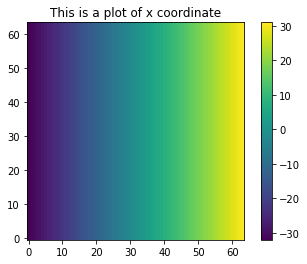

In [23]:
n_pix = 64
xy=np.indices( (n_pix,n_pix),dtype=float)
x = xy[1].copy()- n_pix/2
y = xy[0].copy()- n_pix/2
plt.imshow(x,origin='lower',interpolation='nearest')
plt.title("This is a plot of x coordinate")
plt.colorbar()

In [24]:
# Here is our elliptical exponential galaxy drawing function
# It is always centered on the pixel just above right of the image center.
def drawDisk(r0=4.,flux=1.,e=0.,sigma_psf=3.,n_pix=n_pix):
    # n_pix must be even.
    
    # Build arrays holding the (ky,kx) values
    # irfft2 wants array of this shape:
    tmp = np.ones((n_pix,n_pix//2+1),dtype=float) 
    freqs = np.arange(-n_pix//2,n_pix//2)
    freqs = (2 * np.pi / n_pix)*np.roll(freqs,n_pix//2)
    kx = tmp * freqs[:n_pix//2+1]
    ky = tmp * freqs[:,np.newaxis]

    # Calculate the FT of the PSF
    ft = np.exp( (kx*kx+ky*ky)*(-sigma_psf*sigma_psf/2.))
    
    # Produce the FT of the exponential - for the circular version,
    # it's (1+k^2 r_0^2)**(-3/2)
    # factors to "ellipticize" and scale the k's:
    a = np.power((1+e)/(1-e),0.25)
    ksqp1 = np.square(r0*kx*a) + np.square(r0*ky/a) + 1
    ft *= flux / (ksqp1*np.sqrt(ksqp1))
    
    # Now FFT back to real space
    img = fft.irfft2(ft)
    
    # And roll the origin to the center
    return np.roll(img, (n_pix//2,n_pix//2),axis=(0,1))
    

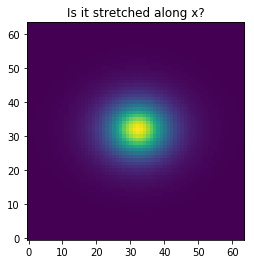

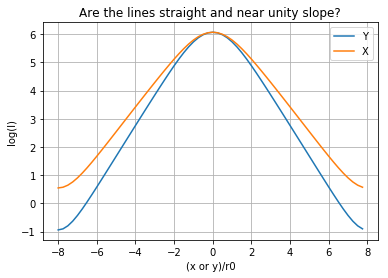

In [25]:
# As a test, let's draw an image with a small PSF size and
# see if it really is exponential. 
# With e>0, it should be extended along x axis
r0=4.
img = drawDisk(e=0.2,flux=1e5,sigma_psf=3.,r0=r0)
plt.imshow(img,origin='lower',interpolation='nearest')
plt.title("Is it stretched along x?")
# And also a plot of log(flux) vs x or y should look linear
plt.figure()
plt.plot(np.arange(-32,32)/r0,np.log(img[:,32]),label='Y')
plt.plot(np.arange(-32,32)/r0,np.log(img[32,:]),label='X')
plt.legend()
plt.title("Are the lines straight and near unity slope?")
plt.xlabel("(x or y)/r0")
plt.ylabel("log(I)")
plt.grid()

## Exercise 1: Aperture photometry

Here we'll try out a few forms of aperture photometry and see how they compare in terms of the S/N ratios they provide on the galaxy flux.

**(a)** Write a function `tophat_flux(img,R)` which implements a simple tophat aperture sum of flux in all pixels within radius `R` of the center of the galaxy.  We will keep the center of our galaxy fixed at pixel \[32,32\] so you don't have to worry about iterating to find the centroid.

Draw a noiseless version of a circular galaxy with the characteristics in the cell below.  Then use your `tophat_flux` function to plot the "curve of growth" for this image, with `R` on the x axis going from 5 to 30 pixels, and the y axis showing the fraction of the total flux that falls in your aperture.

How many scale radii do we need the aperture to be to miss <1% of the flux?

In [26]:
r0 = 4.
e = 0.
flux = 1e4
sigma_psf = 2.

In [27]:
def tophat_flux(img, R, center_x=32, center_y=32):
    yy, xx = np.meshgrid(range(img.shape[0]), range(img.shape[1]))
    distances = np.sqrt((center_x - xx)**2 + (center_y - yy)**2)
    return np.sum(img[np.where(distances < R)])

In [28]:
circ_gal_ = drawDisk(r0=r0,flux=flux,e=e,sigma_psf=sigma_psf)

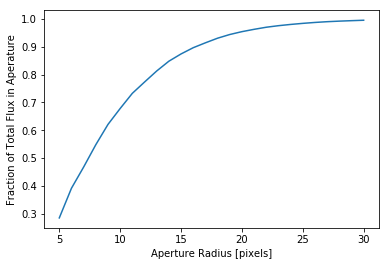

You need 6.75 scale radii


In [29]:
R_arr = np.arange(5., 31.)
cog = np.array([tophat_flux(circ_gal_, R) / flux for R in R_arr])

plt.figure()
plt.plot(R_arr, cog)
plt.xlabel("Aperture Radius [pixels]")
plt.ylabel("Fraction of Total Flux in Aperature")
plt.show()

print("You need {:.2f} scale radii".format(R_arr[np.argmin(np.abs(cog - 0.99))] / r0))

**(b)** Next let's add some background noise to our image, say `n_bg=100`.  
* First, make one such noisy version of your galaxy and `imshow` it.  
* Then, using **analytic** methods, estimate what the variance of your aperture flux measurements will be when `R=10`.  
* Finally, make 1000 different realizations of your noisy galaxy and measure their `tophat_flux` to see whether the real variance of the flux measurements matches your prediction.


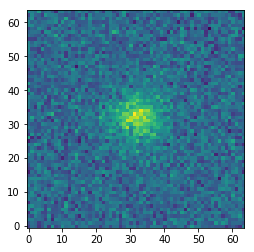

In [30]:
circ_gal_noise_ = addBackground(circ_gal_, 100)
plt.imshow(circ_gal_noise_, origin='lower', interpolation='nearest')

**(c)** Now create a plot of the S/N level of the flux measurement vs the radius `R` of the aperture.  Here the signal is the mean, and the noise the std deviation, of the `tophat_flux` of many noisy measurements of this galaxy.  You can use either an analytic or numeric estimate of these quantities.  Report what the optimal tophat S/N is, and what `R` achieves it.

In [ ]:
# your work here...

**(d)** Repeat part (c), but this time use a *Gaussian* aperture whose width $\sigma_w$ you vary to optimize the S/N ratio of the aperture flux, i.e. a function `gaussian_flux(img,sigma_w)` is needed.  Which performs better, the optimized tophat or the optimized Gaussian?

In [ ]:
# your work here...

## Exercise 2: Spurious color

This time let's consider that we want to measure an accurate $g-r$ color for our galaxy, but the seeing is $\sigma_{\rm PSF}=2$ pixels in the $r$ image but $\sigma_{\rm PSF}=2.5$ pixels in the $g$ image.  Let's see how the size of our aperture biases our color measurement.

**(a)** Draw a noiseless $g$-band and a noiseless $r$-band image of our galaxy.  Let's assume that the true color $g-r \equiv 2.5\log_10(f_r/f_g) = 0,$ i.e. that the $g$ and $r$ fluxes of the galaxy are both equal to our nominal `flux`.  Plot the difference between the two images: are they the same?

In [ ]:
# your work here...

**(b)** Using either your Gaussian or your tophat aperture code, plot the *measured* $g-r$ color of the galaxy as a function of the size of the aperture.  Since the true color is zero, this measurement is the size of the systematic error that is being made in color because of mismatched *pre-seeing* apertures.

In [ ]:
# your work here...

We can see here that a naive use of "matched" apertures can cause significant spurious color, even when the aperture has a sigma that is many times that of the galaxy and PSF. But the tophat does better.  So without any kind of PSF matching, we have to use algorithms with non-optimal S/N in order to approach true colors.

## Exercise 3: Degradation of ellipticity measurements by seeing

It's hard to measure the shape of a galaxy that is not resolved by the PSF.  That means that poorly-resolved galaxies are less useful for detecting weak-lensing (WL) shear.  Let's see if we can quantify this by using the Fisher matrix to determine the best possible measurement accuracy on the parameter $e$ of our model (we'll make things easy by holding all other parameters of the galaxy model as fixed).

Remember how the Fisher matrix works: for an image signal $I_{xy}$ and noise $\sigma_{xy}$ in each pixel, the Fisher information for a parameter $\theta$ is
$$ F_{\theta\theta} = \sum_{xy} \frac{1}{\sigma^2_{xy}} \left(\frac{\partial I_{xy}}{\partial\theta}\right)^2.$$

Here we're interested in $\theta=e$.

**(a)** Draw two versions of our standard galaxy, with $e = \pm0.01.$  Use these to calculate and plot the quantity we need, $\frac{\partial I_{xy}}{\partial e}.$  Comment on how this picture relates to the fact that we like to measure WL shear using the moment of $x^2-y^2$.

In [ ]:
# your work here...

**(b)** Use this to calculate the best achievable measurement accuracy on $e$ for our standard image.

In [ ]:
# your work here...

**(c)** Make a graph showing how the optimal $\sigma_e$ varies as the size $\sigma_{\rm PSF}$ of the Gaussian PSF varies from being $0.2\times r_0$ to being $3\times r_0.$.  What's the lesson here?

In [ ]:
# your work here...